# 미래에 볼 영화의 평점 예측하기

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : MovieLens 데이터 살펴보기

In [2]:
# Data Source : https://grouplens.org/datasets/movielens

rating_file_path = "../data/ml-1m/ratings.dat"
movie_file_path = "../data/ml-1m/movies.dat"
user_file_path = "../data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::')
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

In [3]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [8]:
#결측값 탐색
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


# <Step2. 분석> : 탐색적 데이터 분석

In [9]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 년도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

### `[미니 퀴즈 - 3.3]`
- `영화 데이터에 대한 탐색적 데이터 분석을 더 실행해 봅시다. 영화의 연대별 갯수를 탐색해 보세요.`

In [10]:
# 연대별 영화의 개수를 출력합니다.
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


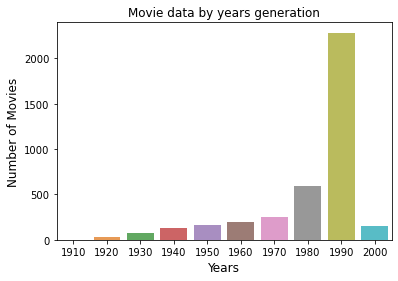

In [11]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

In [13]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


### `[미니 퀴즈 - 3.4]`
- `유저 데이터에 대한 탐색적 데이터 분석을 실행해 봅시다. 아래의 질문들에 답해보세요.` 
    - 유저의 성별 탐색
    - 유저의 연령대 탐색

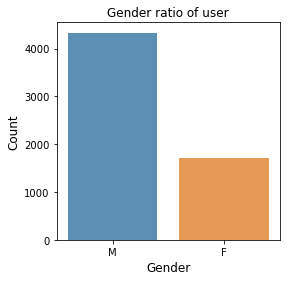

In [14]:
# 유저의 성별을 탐색합니다.
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [15]:
# 유저의 연령대를 탐색합니다.
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [16]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

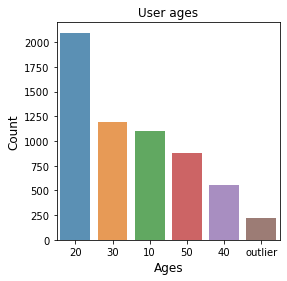

In [17]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

### [평점 데이터의 정보 탐색하기]

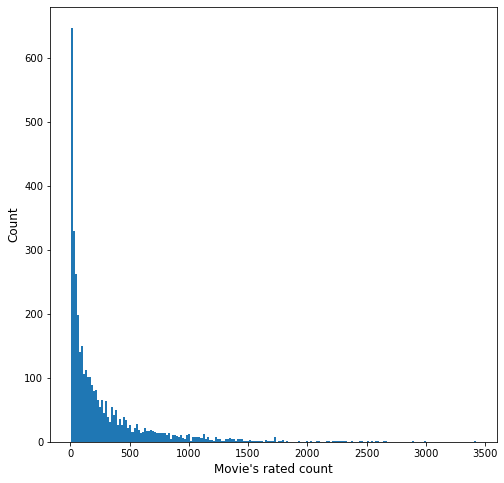

In [18]:
# 각 영화들이 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [21]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby('movie_id')['rating'].agg(
    {'rated_count':'count', 'rating_mean':'mean'})

SpecificationError: nested renamer is not supported

### [user-movie 형태의 테이블로 살펴보기]

In [22]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [25]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

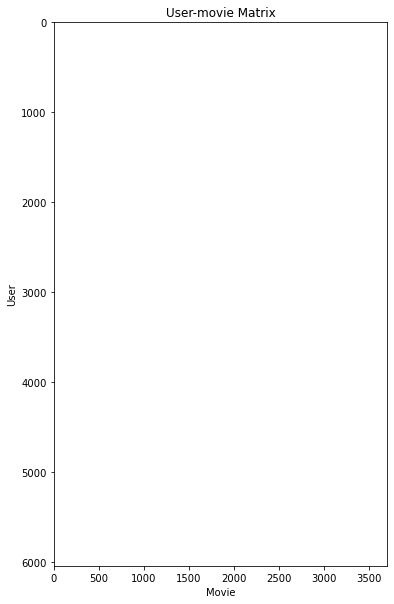

In [26]:
# user-movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

# <Step3. 예측> : 수학적 기법을 활용한 평점 예측

### [SVD를 활용한 빈칸 채우기]

In [28]:
pip install surprise

  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp37-cp37m-win_amd64.whl size=804188 sha256=e53de38c4a6050518b2bc6f58ed272c187a2d82b8984a0a2ac4a683dea7237c8
  Stored in directory: c:\users\ddibo\appdata\local\pip\cache\wheels\14\21\49\2712122e4f70026a9f8c7e0bb6b77fd1da5e84778ec27af6a7
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [29]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

In [30]:
# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [31]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

* 0.0 = ? 값

##### SVD를 이용한 빈칸 채우기 학습

In [32]:
# SVD 사용을 위한 데이터셋을 생성합니다.
data = Dataset.load_from_df(df=df[["user_id", "item_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

In [33]:
# SVD 모델을 학습합니다.
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

In [34]:
# 학습한 모델을 기반으로 빈공간의 점수를 예측합니다.

"""
build_anti_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""

# test_data : 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 아래의 결과는 빈공간(test_data)의 점수를 예측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "predicted rating :", predicted_rating)

Item id 1 | predicted rating : 3.576389094181259
Item id 3 | predicted rating : 3.8008723583534767


In [35]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 1 | real rating : 2.0 | predicted rating : 3.520758708069664
Item id 2 | real rating : 4.0 | predicted rating : 3.758193196541167
Item id 3 | real rating : 4.0 | predicted rating : 3.6503400528087844
Item id 1 | real rating : 2.0 | predicted rating : 3.5655317063995025
Item id 2 | real rating : 5.0 | predicted rating : 3.9027416090821454
Item id 3 | real rating : 4.0 | predicted rating : 3.7327848993393324
Item id 2 | real rating : 5.0 | predicted rating : 3.9230122416359086


### [아직 평가하지 않은 영화의 점수 예측하기]

##### MovieLens 데이터에 SVD 적용하기

In [37]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 230.62 seconds


##### 영화의 점수를 예측할 타겟(특정) 유저 선정

In [39]:
# user_id가 4인 유저의 영화 평가 데이터입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [40]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


##### 타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [41]:
# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [42]:
test_data

[(4, 1, 0),
 (4, 2, 0),
 (4, 3, 0),
 (4, 4, 0),
 (4, 5, 0),
 (4, 6, 0),
 (4, 7, 0),
 (4, 8, 0),
 (4, 9, 0),
 (4, 10, 0),
 (4, 11, 0),
 (4, 12, 0),
 (4, 13, 0),
 (4, 14, 0),
 (4, 15, 0),
 (4, 16, 0),
 (4, 17, 0),
 (4, 18, 0),
 (4, 19, 0),
 (4, 20, 0),
 (4, 21, 0),
 (4, 22, 0),
 (4, 23, 0),
 (4, 24, 0),
 (4, 25, 0),
 (4, 26, 0),
 (4, 27, 0),
 (4, 28, 0),
 (4, 29, 0),
 (4, 30, 0),
 (4, 31, 0),
 (4, 32, 0),
 (4, 33, 0),
 (4, 34, 0),
 (4, 35, 0),
 (4, 36, 0),
 (4, 37, 0),
 (4, 38, 0),
 (4, 39, 0),
 (4, 40, 0),
 (4, 41, 0),
 (4, 42, 0),
 (4, 43, 0),
 (4, 44, 0),
 (4, 45, 0),
 (4, 46, 0),
 (4, 47, 0),
 (4, 48, 0),
 (4, 49, 0),
 (4, 50, 0),
 (4, 51, 0),
 (4, 52, 0),
 (4, 53, 0),
 (4, 54, 0),
 (4, 55, 0),
 (4, 56, 0),
 (4, 57, 0),
 (4, 58, 0),
 (4, 59, 0),
 (4, 60, 0),
 (4, 61, 0),
 (4, 62, 0),
 (4, 63, 0),
 (4, 64, 0),
 (4, 65, 0),
 (4, 66, 0),
 (4, 67, 0),
 (4, 68, 0),
 (4, 69, 0),
 (4, 70, 0),
 (4, 71, 0),
 (4, 72, 0),
 (4, 73, 0),
 (4, 74, 0),
 (4, 75, 0),
 (4, 76, 0),
 (4, 77, 0),
 (4, 78,

In [43]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [44]:
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]

In [45]:
# 예측된 Top 10 영화
target_user_top10_predicted

[(106, 5),
 (246, 5),
 (326, 5),
 (523, 5),
 (602, 5),
 (608, 5),
 (669, 5),
 (750, 5),
 (858, 5),
 (912, 5)]

In [46]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [47]:
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력합니다.
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Nobody Loves Me (Keiner liebt mich) (1994) : 5
Hoop Dreams (1994) : 5
To Live (Huozhe) (1994) : 5
Ruby in Paradise (1993) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Aparajito (1956) : 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : 5
Godfather, The (1972) : 5
Casablanca (1942) : 5


In [48]:
 # 타겟 유저의 기존 선호 영화와 비교합니다.
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:10]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


# <Step4. 평가> : 예측 모델 평가하기

##### RMSE 계산하기

In [49]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 213.88 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8621


0.8621177566303532

### [실제 평점과의 비교 시각화]

In [50]:
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

In [51]:
test_data

[(4, 260, 5),
 (4, 480, 4),
 (4, 1036, 4),
 (4, 1097, 4),
 (4, 1196, 2),
 (4, 1198, 5),
 (4, 1201, 5),
 (4, 1210, 3),
 (4, 1214, 4),
 (4, 1240, 5),
 (4, 1387, 5),
 (4, 1954, 5),
 (4, 2028, 5),
 (4, 2366, 4),
 (4, 2692, 5),
 (4, 2947, 5),
 (4, 2951, 4),
 (4, 3418, 4),
 (4, 3468, 5),
 (4, 3527, 1),
 (4, 3702, 4)]

In [52]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [53]:
target_user_movie_predict_dict

{260: 4.021113925489954,
 480: 3.49145915726929,
 1036: 4.095410905894476,
 1097: 4.3360754428726205,
 1196: 3.6580709403444533,
 1198: 4.40184445165957,
 1201: 4.129758572412063,
 1210: 3.2347554699376433,
 1214: 4.470147496019157,
 1240: 4.289313718181803,
 1387: 4.494426796031226,
 1954: 4.278191765697938,
 2028: 4.554587746691203,
 2366: 3.9742962756690328,
 2692: 4.362034049694977,
 2947: 4.116596945477755,
 2951: 3.9764342160799355,
 3418: 4.675714493222717,
 3468: 4.793640342384937,
 3527: 3.0953175987161323,
 3702: 3.685653734118822}

In [54]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.02
movie 2 : Jurassic Park (1993) - 4 / 3.49
movie 3 : Die Hard (1988) - 4 / 4.1
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.34
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.66
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.4
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.13
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.23
movie 9 : Alien (1979) - 4 / 4.47
movie 10 : Terminator, The (1984) - 5 / 4.29
movie 11 : Jaws (1975) - 5 / 4.49
movie 12 : Rocky (1976) - 5 / 4.28
movie 13 : Saving Private Ryan (1998) - 5 / 4.55
movie 14 : King Kong (1933) - 4 / 3.97
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.36
movie 16 : Goldfinger (1964) - 5 / 4.12
movie 17 : Fistful of Dollars, A (1964) - 4 / 3.98
movie 18 : Thelma & Louise (1991) - 4 / 4.68
movie 19 : Hustler, The (1961) - 5 / 4.79
movie 20 : Predator (1987) - 1 / 3.1
movie 21 : Mad Max (1979) - 4 / 3.69


##### 결과의 시각화

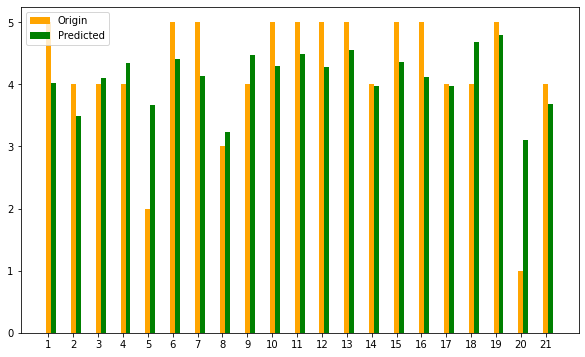

In [55]:
# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list
 
# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()